# Detecting Spikes in Continuous Recordings

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal

## 1 Preparation

Define the utility functions required for this session.

In [2]:
class utils:
    def plot_frequency_response(b, a, cutoff):
        w, h = signal.freqz(b, a, fs=30000)
        plt.semilogx(w, np.abs(h), label="Filter")
        if not isinstance(cutoff, list):
            cutoff = [cutoff]
        for c in cutoff:
            plt.axvline(c, color="red", label="Cutoff")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Gain [a.u.]")
        plt.legend()

Download the data required for this session

In [3]:
import requests

url = "https://uni-bonn.sciebo.de/s/bRc91rzP45q2C84"
fname = "raw_tetrode_recording.parquet"
response = requests.get(f"{url}/download")
print("Downloading Data ...")
with open(fname, "wb") as file:
    file.write(response.content)
print("Done!")

Done!

## 2 Inspecting Raw Extracellular Recordings

In this notebook, our aim is to extract spike waveforms from raw
electrophysiological recordings from a tetrode (a probe with four
separate electrodes). In this section we are going to load the data into
a pandas data frame and explore its contents.

| Code | Description |
|------------------------------------|------------------------------------|
| `df = pd.read_parquet("data.parquet")` | Read a Parquet file into a pandas data frame |
| `df.head(5)` | Print the first 5 rows of `df` |
| `df.loc[0:10]` | Get all entries in `df` between the index values `0` and `10` |
| `df.loc[tmin:tmax]` | Get all entries in `df` between the index values `tmin` and `tmax` |
| `df.col1` | Access the values stored in the column labeled `"col1"` |
| `df.index` | Access the index of the data frame `df` |
| `df.index.max(0)` | Get the maximum index of `df` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 1**</span> Load the file
`"raw_tetrode_recording.parquet"` into a pandas data frame and print the
first 10 rows

*Solution.*

In [4]:
df = pd.read_parquet("raw_tetrode_recording.parquet")
df.head(10)

<span class="theorem-title">**Exercise 2**</span> what is the duration
of the recording and how many samples (i.e. rows) are there? What is the
sampling rate of the recording?

*Solution.*

In [6]:
sampling_rate = len(df) / df.index.max(0)
sampling_rate

30000.015104174978

<span class="theorem-title">**Example 1**</span> Plot the data recorded
at `"Ch1"` between `tmin=0` and `tmax=3`.

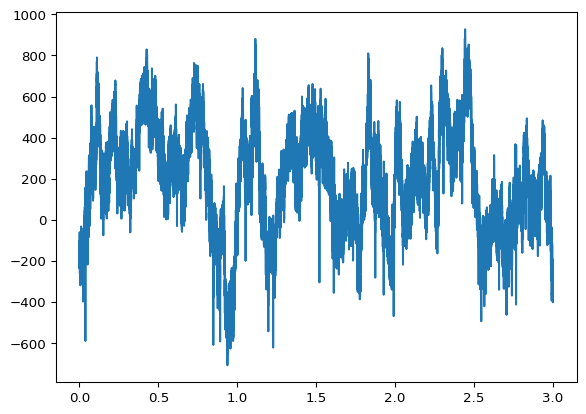

In [8]:
tmin, tmax = 0, 3
data = df["Ch1"].loc[tmin:tmax]
plt.plot(data.index, data)

<span class="theorem-title">**Exercise 3**</span> Plot the data recorded
at `"Ch2"` between `tmin=10` and `tmax=20`.

*Solution.*

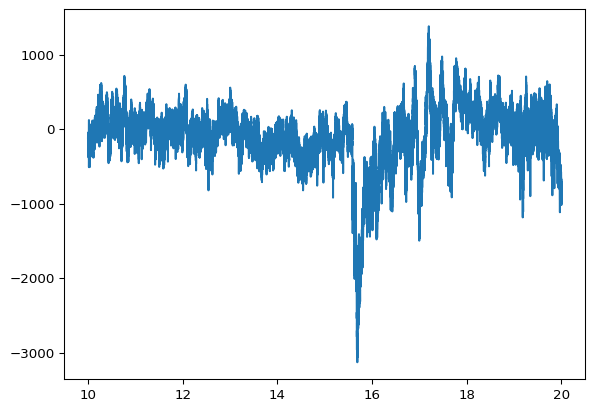

In [9]:
tmin, tmax = 10, 20
data = df["Ch2"].loc[tmin:tmax]
plt.plot(data.index, data)

<span class="theorem-title">**Exercise 4**</span> Compute the difference
between the data recorded at channels `"Ch1"` and `"Ch2"` between
`tmin=10` and `tmax=20`, and plot it.

*Solution.*

Text(0, 0.5, 'Voltage [muV]')

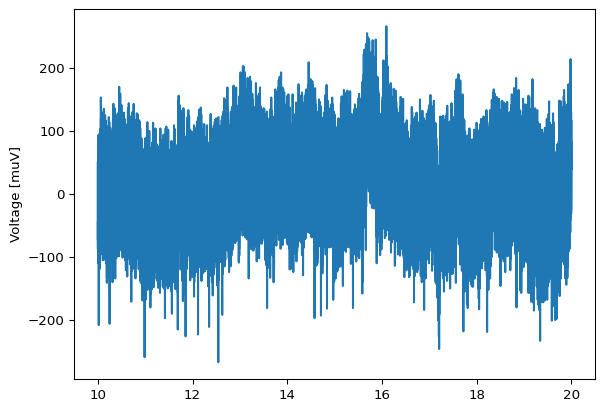

In [11]:
tmin, tmax = 10, 20
data = df["Ch1"].loc[tmin:tmax] - df["Ch2"].loc[tmin:tmax]
plt.plot(data.index, data)
plt.ylabel("Voltage [muV]")

<span class="theorem-title">**Exercise 5**</span> Plot the data recorded
at channels `"Ch1"` and `"Ch3"` between `tmin=0.05` and `tmax=0.06` in
the same plot.

*Solution.*

Text(0, 0.5, 'Voltage [muV]')

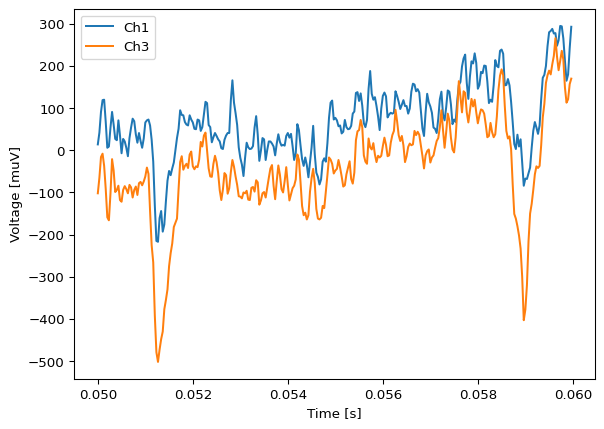

In [13]:
tmin, tmax = 0.05, 0.06
for ch in ["Ch1", "Ch3"]:
    data = df[ch].loc[tmin:tmax]
    plt.plot(data.index, data, label=ch)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Voltage [muV]")

## 3 Filtering

Extracellular electrophysiological recordings contain raw voltage traces
from every electrode. These recordings contain the spikes we want to
analyze but they also contain other signals like local field potentials
(LFPs) and artifacts. To extract the spikes we have to filter out the
part of the signal that contains the spikes. In this section, we will
explore how to construct infinite-impulse response (IIR) filter and
apply them to the data to extract specific parts of the frequency
spectrum.

| Code | Description |
|------------------------------------|------------------------------------|
| `b, a=signal.butter(4, 100, "lowpass", fs)` | Generate a 4-th order Butterworth `"lowpass"` filter with a cutoff frequency of `100` Hz at the sampling rate `fs` |
| `b, a=signal.butter(6, 2000, "highpass", fs)` | Generate a 6-th order `"highpass"` filter with a cutoff frequency of `2000` Hz |
| `b, a=signal.butter(6, [100, 2000], "bandpass", fs)` | Generate a 6-th order `"bandpass"` filter with a low cutoff at `100` Hz and a high cutoff at `2000` Hz |
| `utils.plot_frequency_response(b, a, cutoff)` | Plot the frequency response of the filter with the coefficients `a` and `b` and mark the cutoff |
| `signal.filtfilt(b,a,data)` | Apply the filter with coefficients `b` and `a` to `data`, forwards and backwards |
| `signal.filtfilt(b,a,data,axis=0)` | Apply the filter with coefficients `b` and `a` across the first dimension of `data` |
| `plt.subplot(2, 1, 1)` | Generate the 1st subplot in a 2-by-1 grid |
| `plt.subplot(2, 1, 2)` | Generate the 2nd subplot in a 2-by-1 grid |
| `df.loc[:] = x` | Overwrite the content of `df` with `x` |

------------------------------------------------------------------------

<span class="theorem-title">**Example 2**</span> Create a Butterworth
`"lowpass"` filter with `order=4`, `cutoff=500` and `fs=30000` and plot
its frequency response.

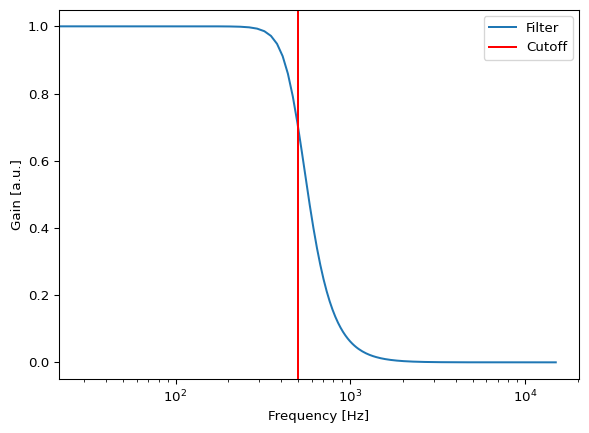

In [15]:
cutoff = 500
order = 4
b, a = signal.butter(order, cutoff, btype="lowpass", fs=30000)
utils.plot_frequency_response(b, a, cutoff=cutoff)

<span class="theorem-title">**Example 3**</span> Use `signal.filtfilt()`
to apply the filter coefficients `b` and `a` to the `data` recorded at
`"Ch1"` between `tmin=0` and `tmax=3` and plot the raw and filtered
signal in a 2-by-1 subplot grid.

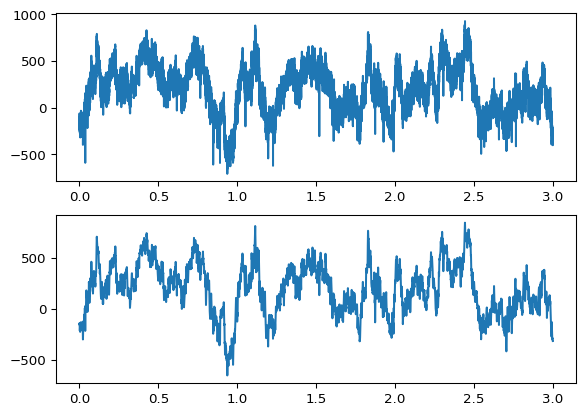

In [16]:
tmin, tmax = 0, 3
data = df["Ch1"].loc[tmin:tmax]
data_filt = signal.filtfilt(b, a, data)

plt.subplot(2, 1, 1)
plt.plot(data.index, data)
plt.subplot(2, 1, 2)
plt.plot(data.index, data_filt)

<span class="theorem-title">**Exercise 6**</span> Create a Butterworth
`"lowpass"` filter with `order=4`, `cutoff=300` and `fs=30000` and plot
its frequency response.

*Solution.*

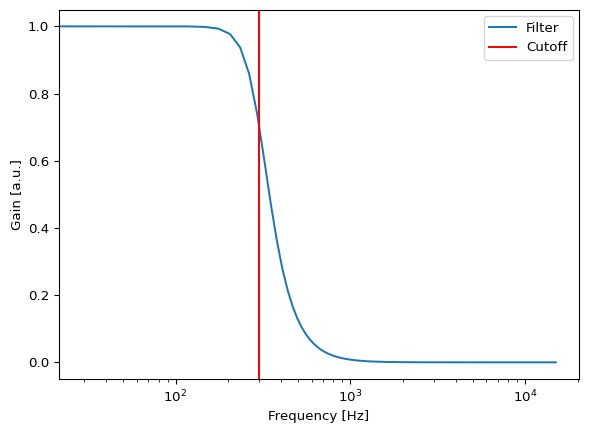

In [17]:
cutoff = 300
order = 4
b, a = signal.butter(order, cutoff, btype="lowpass", fs=30000)
utils.plot_frequency_response(b, a, cutoff=cutoff)

<span class="theorem-title">**Exercise 7**</span> Use
`signal.filtfilt()` to apply the filter coefficients `b` and `a` to the
`data` recorded at `"Ch2"` between `tmin=0` and `tmax=3` and plot the
raw and filtered signal in a 2-by-1 subplot grid.

*Solution.*

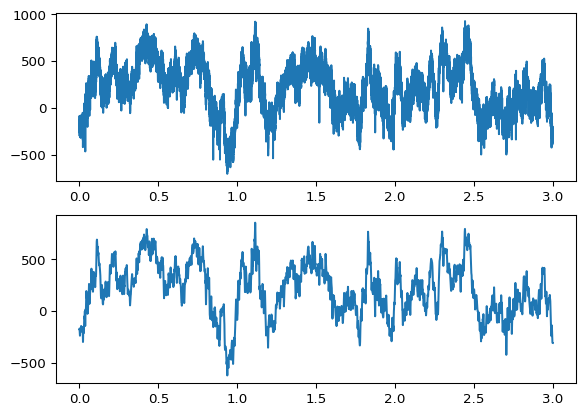

In [19]:
tmin, tmax = 0, 3
data = df["Ch2"].loc[tmin:tmax]
data_filt = signal.filtfilt(b, a, data)

plt.subplot(2, 1, 1)
plt.plot(data.index, data)
plt.subplot(2, 1, 2)
plt.plot(data.index, data_filt)

<span class="theorem-title">**Exercise 8**</span> Create a Butterworth
`"highpass"` filter with `order=6`, `cutoff=1000` and `fs=30000` and
plot its frequency response.

*Solution.*

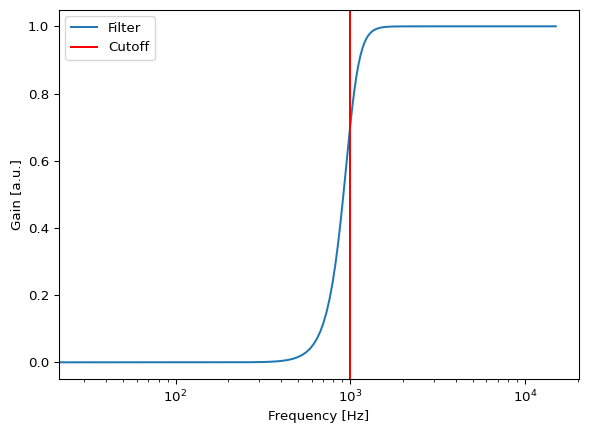

In [21]:
cutoff = 1000
order = 6
b, a = signal.butter(order, cutoff, btype="highpass", fs=30000)
utils.plot_frequency_response(b, a, cutoff=cutoff)

<span class="theorem-title">**Exercise 9**</span> Use
`signal.filtfilt()` to apply the filter coefficients `b` and `a` to the
`data` recorded at `"Ch3"` between `tmin=15` and `tmax=20` and plot the
raw and filtered signal in a 2-by-1 subplot grid.

*Solution.*

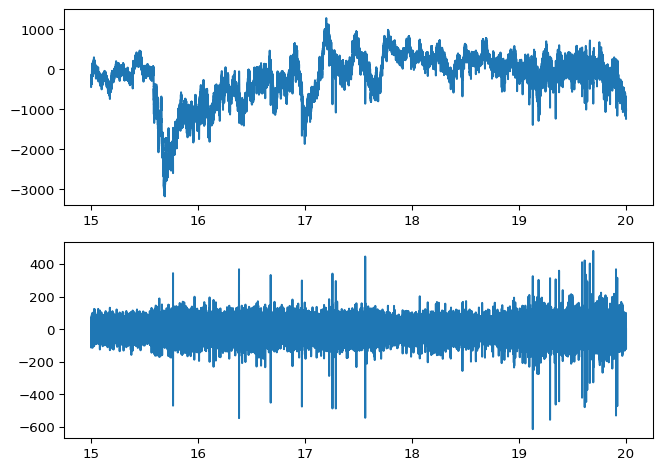

In [23]:
tmin, tmax = 15, 20
data = df["Ch3"].loc[tmin:tmax]
data_filt = signal.filtfilt(b, a, data)

plt.subplot(2, 1, 1)
plt.plot(data.index, data)
plt.subplot(2, 1, 2)
plt.plot(data.index, data_filt)
plt.tight_layout()

<span class="theorem-title">**Exercise 10**</span> Create a Butterworth
`"bandpass"` filter with `order=6`, `cutoff=[500, 5000]` and and
`fs=30000` and plot its frequency response.

*Solution.*

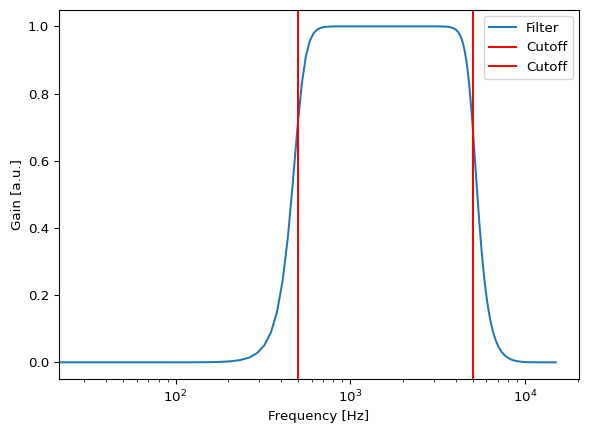

In [25]:
cutoff = [500, 5000]
order = 6
b, a = signal.butter(order, cutoff, btype="bandpass", fs=30000)
utils.plot_frequency_response(b, a, cutoff=cutoff)

<span class="theorem-title">**Exercise 11**</span> Use
`signal.filtfilt()` to apply the filter coefficients `b` and `a` to the
`data` recorded at `"Ch4"` between `tmin=50` and `tmax=60` and plot the
raw and filtered signal in a 2-by-1 subplot grid.

*Solution.*

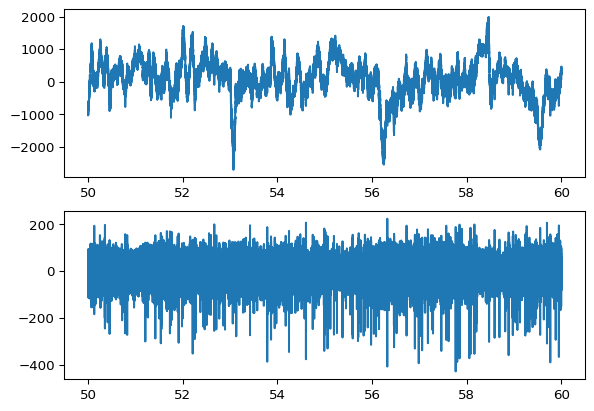

In [27]:
tmin, tmax = 50, 60
data = df["Ch4"].loc[tmin:tmax]
data_filt = signal.filtfilt(b, a, data)

plt.subplot(2, 1, 1)
plt.plot(data.index, data)
plt.subplot(2, 1, 2)
plt.plot(data.index, data_filt)

<span class="theorem-title">**Exercise 12**</span> Use
`signal.filtfilt()` to apply the filter coefficients `b` and `a` to the
whole data frame `df` across `axis=0` and return the filtered `data`.
Then, use `df.loc[:]=data` to overwrite `df` with the filtered data.

*Solution.*

In [29]:
data = signal.filtfilt(b, a, df, axis=0)
df.loc[:] = data

## 4 Detecting Spikes

To detect spikes, we need to estimate the level of noise in the data and
define a threshold (i.e. 5 times the noise level) to categorize signals
that cross this threshold as spikes. The noise level is calculated as
the median absolute deviation (MAD) of the signal:

$$
MAD=median(|X_i - median(X)|)
$$

This is a useful measure because the median is more robust to large
deviations compared to the mean. Because an action potential is a
depolarization (i.e. a positive spike) in the cell, it is reflected as a
negative spike in the extracellular recording. In this section, we are
going to explore how to compare the signal against a noise threshold to
identify the times at which spikes occur.

| Code | Description |
|------------------------------------|------------------------------------|
| `np.median(x)` | Compute the median of the values in `x` |
| `np.abs(x)` | Get the absolute value of `x` |
| `x = (df < threshold).any(axis=1)` | Return an array that is `True` for all elements of `df` where any column is smaller than the `threshold` |
| `x = x.astype(int)` | Convert the values in `x` to integers |
| `np.diff(x)` | Compute the difference between subsequent elements of `x` |
| `peak_time = df.loc[tmin:tmax].idxmin()` | Get the index of the minimum value for each column in `df` between `tmin` and `tmax` |
| `peak_time = df.loc[tmin:tmax].idxmin().min()` | Get the index of the minimum value in `df` between `tmin` and `tmax` across all columns |

------------------------------------------------------------------------

<span class="theorem-title">**Example 4**</span> Compute the robust
noise level `sigma` for first channel as the median absolute deviation
(MAD) of the data recorded at `"Ch1"`.

In [31]:
x = df["Ch1"]
sigma = np.median(np.abs(x - x.median(axis=0)), axis=0)
sigma

23.840796979425427

<span class="theorem-title">**Exercise 13**</span> Compute the robust
noise level `sigma` for the data recorded at `"Ch2"`. Does this mean the
signal recorded at `"Ch2"` is more or less noisy than the signal at
`"Ch1"`?

*Solution.*

In [32]:
x = df["Ch2"]
sigma = np.median(np.abs(x - x.median(axis=0)), axis=0)
sigma

25.290102706075356

<span class="theorem-title">**Example 5**</span> Find which samples in
`df` are below the `threshold` of `b * sigma` for `b=2` and assign them
to a variable `is_below_thresh`. Convert that variable to integers and
print the total number of samples below the `threshold`.

In [34]:
b = 2
threshold = -1 * (np.mean(df, axis=0) + b * sigma)
is_below_thresh = (df < threshold).any(axis=1)
is_below_thresh = is_below_thresh.astype(int)
sum(is_below_thresh)

320593

<span class="theorem-title">**Example 6**</span> Get the time points
where difference between the values of `is_below_threshold` is `1`,
i.e. where the signal crosses from above to below the threshold and
print the number of `crossing_times`.

In [35]:
is_crossing = is_below_thresh.diff() == 1
crossing_times = df[is_crossing].index
len(crossing_times)

85050

<span class="theorem-title">**Exercise 14**</span> Set `b=4` and find
which samples in `df` are below the `threshold` of `b * sigma` for `b=4`
and assign them to a variable `is_below_thresh`. Convert that variable
to integers and print the total number of samples below the `threshold`.

*Solution.*

In [36]:
b = 4
threshold = -1 * (np.mean(df, axis=0) + b * sigma)
is_below_thresh = (df < threshold).any(axis=1)
is_below_thresh = is_below_thresh.astype(int)
sum(is_below_thresh)

43714

<span class="theorem-title">**Exercise 15**</span> Get the time points
where difference between the values of `is_below_threshold` is `1`,
i.e. where the signal crosses from above to below the threshold and
print the number of `crossing_times`.

*Solution.*

In [38]:
is_crossing = is_below_thresh.diff() == 1
crossing_times = df[is_crossing].index
len(crossing_times)

12315

<span class="theorem-title">**Exercise 16**</span> Set `b=5`, get the
times where the signal crosses the `b*sigma` threshold and print the
total number of `crossing_times`.

*Solution.*

In [40]:
b = 5
threshold = -1 * (np.mean(df, axis=0) + b * sigma)
is_below_thresh = (df < threshold).any(axis=1)
is_below_thresh = is_below_thresh.astype(int)
is_crossing = is_below_thresh.diff() == 1
crossing_times = df[is_crossing].index
len(crossing_times)

5062

<span class="theorem-title">**Example 7**</span> For the first crossing
time, get the lowest point (i.e. the negative peak) within a
`window=2*1e-3` seconds and get the channel voltages at this
`peak_time`.

In [42]:
window = 2 * 1e-3
tmin = crossing_times[0]
tmax = tmin + window
peak_time = df.loc[tmin:tmax].idxmin().min()
df.loc[peak_time]

Ch1    -80.497902
Ch2    -82.152938
Ch3   -143.714896
Ch4    -85.106740
Name: 0.011866667284722287, dtype: float64

<span class="theorem-title">**Exercise 17**</span> Get the peak time for
the 10th crossing time and get the channel voltages at the peak time.
Which channel recorded the largest signal for this spike?

*Solution.*

In [43]:
window = 2 * 1e-3
tmin = crossing_times[9]
tmax = tmin + window
peak_time = df.loc[tmin:tmax].idxmin().min()
df.loc[peak_time]

Ch1   -117.819185
Ch2    -88.697246
Ch3   -182.508835
Ch4    -93.611148
Name: 0.06706667015972258, dtype: float64

<span class="theorem-title">**Exercise 18**</span> Complete the loop
below to get the `peak_time` for every crossing time `c_t` and append it
to the list `spike_times`.

In [45]:
window = 2 * 1e-3
spike_times = []
for c_t in crossing_times:
    tmin = # your code here
    tmax = # your code here
    peak_time= # your code here
    spike_times.append(peak_time)
len(crossing_times), len(spike_times)

*Solution.*

In [46]:
window = 2 * 1e-3
spike_times = []
for c_t in crossing_times:
    tmin = c_t
    tmax = tmin + window
    peak_time = df.loc[tmin:tmax].idxmin().min()
    spike_times.append(peak_time)
len(crossing_times), len(spike_times)

(5062, 5062)

<span class="theorem-title">**Example 8**</span> Plot the recording at
`"Ch1"` and mark the `spike_times` with red dots. Then, set the
`plt.xlim()` so the plot shows the time between `0.03` and `0.04`
seconds.

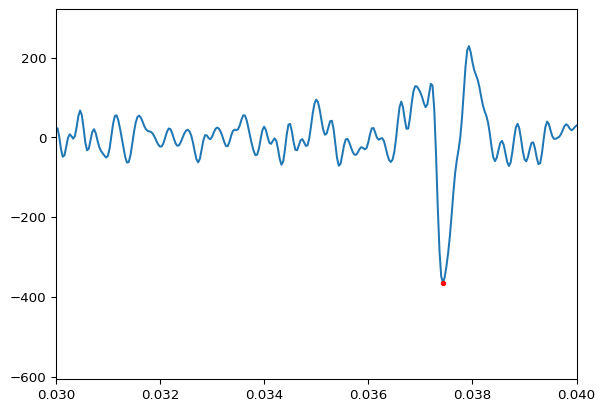

In [47]:
ch = "Ch1"
plt.plot(df[ch].index, df[ch])
plt.plot(df[ch].loc[spike_times].index, df[ch].loc[spike_times], "r.")
plt.xlim(0.03, 0.04)

<span class="theorem-title">**Exercise 19**</span> Plot the recording at
`"Ch4"` and mark the `spike_times` with red dots. Then, set the
`plt.xlim()` so the plot shows the time between `0.03` and `0.04`
seconds.

*Solution.*

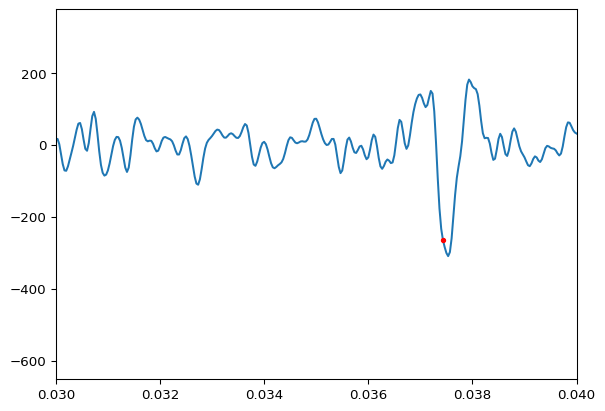

In [48]:
ch = "Ch4"
plt.plot(df[ch].index, df[ch])
plt.plot(df[ch].loc[spike_times].index, df[ch].loc[spike_times], "r.")
plt.xlim(0.03, 0.04)

<span class="theorem-title">**Exercise 20**</span> Complete the loop
below to plot the recording at all channels and mark the `spike_times`
with red dots. Then, set the `plt.xlim()` so the plot shows the time
between `0.03` and `0.04` seconds.

In [50]:
for i, ch in enumerate(df.columns):
    plt.subplot(4, 1, i + 1)
    plt.plot( # your code here
    plt.plot( # your code here
    plt.xlim(0.03, 0.04)

*Solution.*

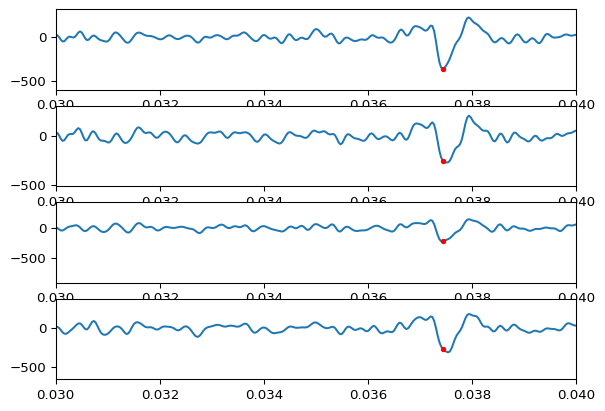

In [51]:
for i, ch in enumerate(df.columns):
    plt.subplot(4, 1, i + 1)
    plt.plot(df[ch].index, df[ch])
    plt.plot(df[ch].loc[spike_times].index, df[ch].loc[spike_times], "r.")
    plt.xlim(0.03, 0.04)

<span class="theorem-title">**Exercise 21**</span> Plot the recording at
`"Ch3"` and mark the `spike_times` with red dots. Then, set the
`plt.xlim()` so the plot shows the time between `1` and `1.5` seconds.

*Solution.*

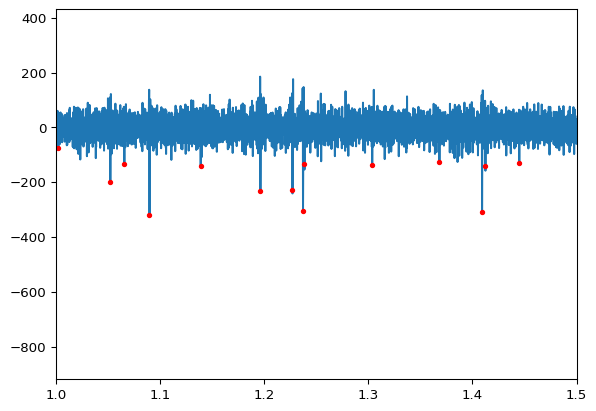

In [53]:
ch = "Ch3"
plt.plot(df[ch].index, df[ch])
plt.plot(df[ch].loc[spike_times].index, df[ch].loc[spike_times], "r.")
plt.xlim(1, 1.5)

<span class="theorem-title">**Exercise 22**</span> BONUS: Change the
detection threshold `b*sigma`, then re-compute and plot the
`spike_times` to see how the threshold affects the number of detected
spikes.\`

## 5 Extract and Visualize Spike Waveforms

Now that we have the times at which spikes occur, we can extract the
spike waveforms that we will use for spike sorting from the signal.
Those spikes will be stored in a 3D matrix where the first dimension
represents the spikes, the second represents the points in time and the
third dimension represents the channels. By visualizing the waveforms
across channels, we will see the differences in spike shape, amplitude
and arrival times that we can use to sort the spikes later on.

| Code | Description |
|------------------------------------|------------------------------------|
| `df.columns` | Get the columns of the data frame `df` |
| `df.to_numpy()` | Export the data in `df` to a numpy array |
| `x = []` | Define an empty list `x` |
| `x.append(k)` | Append `k` to the list `x` |
| `x = np.stack(x)` | Stack a list of numpy arrays into a single multi-dimensional numpy array |
| `x[:,:,0]` | Get the first element along the 3rd dimension of `x` |
| `x[0:10,:,1]` | Get the first 10 elements along the first dimension and the first element along the 3rd dimension of `x` |
| `x.mean(axis=0)` | Get the mean along the first dimension of `x` |
| `df.loc[tmin:tmax].to_numpy()` | Get all rows of `df` between the index values `tmin` and `tmax` and export them to a numpy array |

------------------------------------------------------------------------

<span class="theorem-title">**Example 9**</span> Get the `waveform` of
the 1st spike by extracting the signal recorded within +/- `2*-1e3`
seconds around the spike time.

In [56]:
window = 2 * 1e-3
tmin = spike_times[0] - window
tmax = spike_times[0] + window
waveform = df.loc[tmin:tmax]

<span class="theorem-title">**Example 10**</span> Plot the extracted
`waveform` for every channel and add a `plt.legend()`.

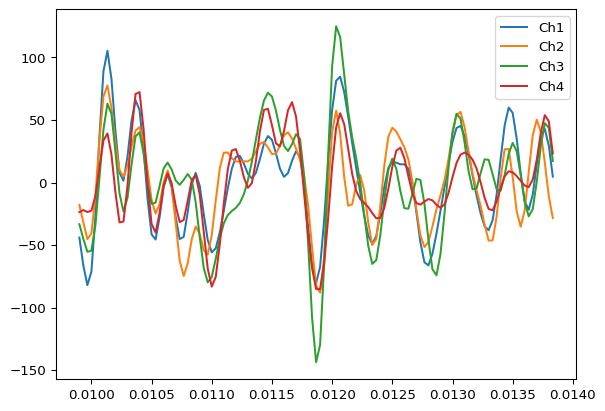

In [57]:
plt.plot(waveform.index, waveform, label=waveform.columns)
plt.legend()

<span class="theorem-title">**Exercise 23**</span> Get the `waveform` of
the 1st spike by extracting the signal recorded within +/- `0.5*-1e3`
seconds around the spike time and plot the extracted spike for every
channel.

*Solution.*

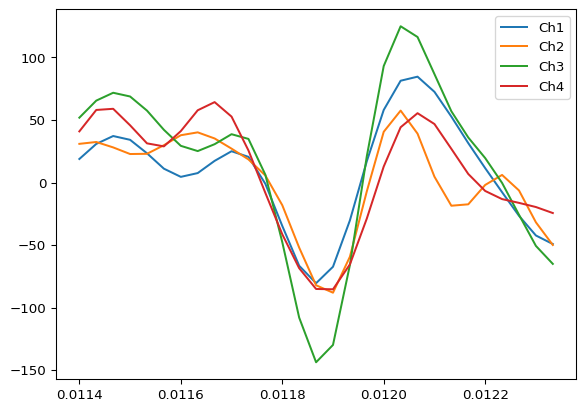

In [58]:
window = 0.5 * 1e-3
tmin = spike_times[0] - window
tmax = spike_times[0] + window
waveform = df.loc[tmin:tmax]
plt.plot(waveform.index, waveform, label=waveform.columns)
plt.legend()

<span class="theorem-title">**Exercise 24**</span> Get the `waveform` of
the 2nd spike by extracting the signal recorded within +/- `0.5*-1e3`
seconds around the spike time and plot the extracted spike for every
channel.

*Solution.*

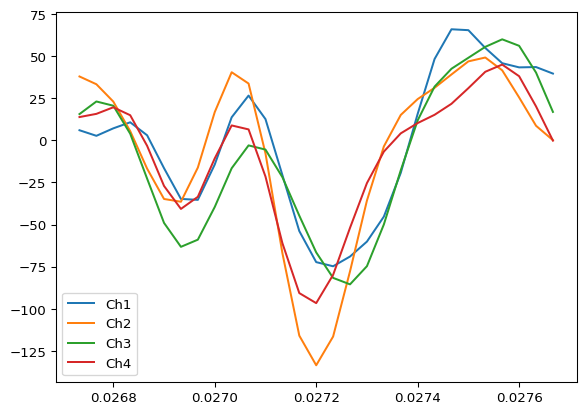

In [60]:
window = 0.5 * 1e-3
tmin = spike_times[1] - window
tmax = spike_times[1] + window
waveform = df.loc[tmin:tmax]
plt.plot(waveform.index, waveform, label=waveform.columns)
plt.legend()

<span class="theorem-title">**Exercise 25**</span> Complete the loop
below by extracting the `waveform` for every item `s` in the list of
`spike_times`.

In [62]:
window = 0.5 * 1e-3
waveforms = []
for s in spike_times:
    waveform = # your code here
    waveforms.append(waveform.to_numpy())
waveforms = np.stack(waveforms)
waveforms.shape

*Solution.*

In [63]:
window = 0.5 * 1e-3
waveforms = []
for s in spike_times:
    waveform = df.loc[s - window : s + window]
    waveforms.append(waveform.to_numpy())
waveforms = np.stack(waveforms)
waveforms.shape

(5062, 29, 4)

<span class="theorem-title">**Example 11**</span> Plot the first `5`
`waveforms` for each channel.

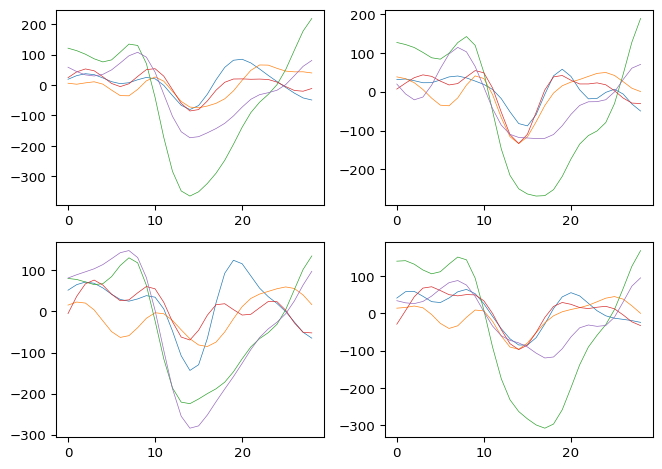

In [65]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(waveforms[:5, :, i].T, linewidth=0.5)
plt.tight_layout()

<span class="theorem-title">**Exercise 26**</span> Plot the last `5`
`waveforms` for each channel.

*Solution.*

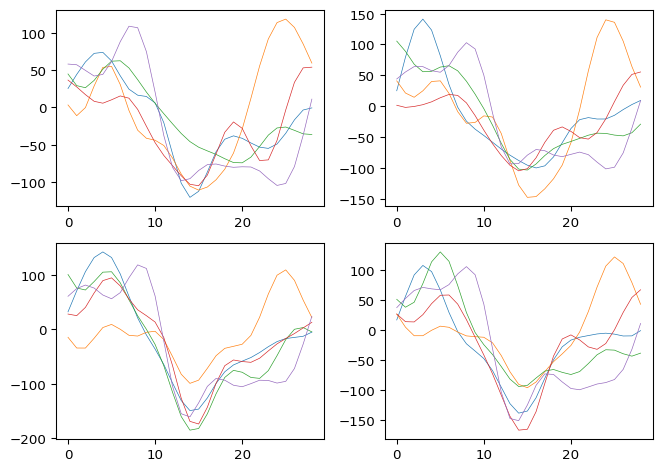

In [66]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(waveforms[-5:, :, i].T, linewidth=0.5)
plt.tight_layout()

<span class="theorem-title">**Exercise 27**</span> Compute the mean
waveform for every channel (i.e. `waveforms.mean(axis=0)`) and plot them
in the same graph.

*Solution.*

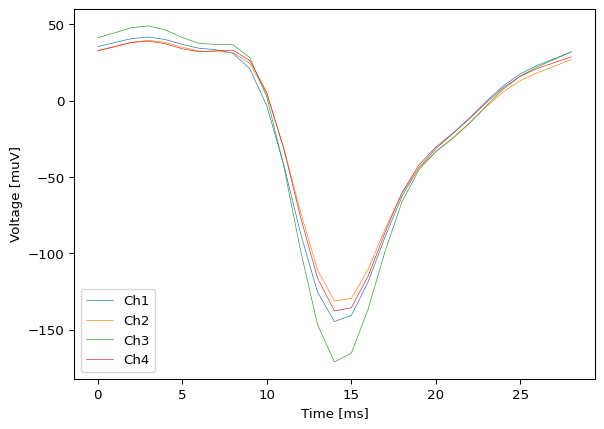

In [68]:
plt.plot(waveforms.mean(axis=0), linewidth=0.5, label=df.columns)
plt.xlabel("Time [ms]")
plt.ylabel("Voltage [muV]")
plt.legend()